# Fashion MNIST Dataset

In [4]:
# Install library
%pip install torch torchvision


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
# Import libraries

import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
from sklearn.decomposition import PCA

## Data Exploration and Processing

In [6]:
#  Define transform to normalize data

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

In [7]:
# Download training data

trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)

trainset

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: /Users/abhishekdas/.pytorch/F_MNIST_data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [8]:
# Load trainset

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

trainloader

In [9]:
# Download test data

testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)

testset

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: /Users/abhishekdas/.pytorch/F_MNIST_data/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [10]:
# Load testset

testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

testloader

In [11]:
# Check shape of images and labels

images, labels = next(iter(trainloader))

print("Images shape:",images.shape)
print("Labels shape:",labels.shape)

Images shape: torch.Size([64, 1, 28, 28])
Labels shape: torch.Size([64])


Image shape: torch.Size([1, 28, 28])
Label: 9


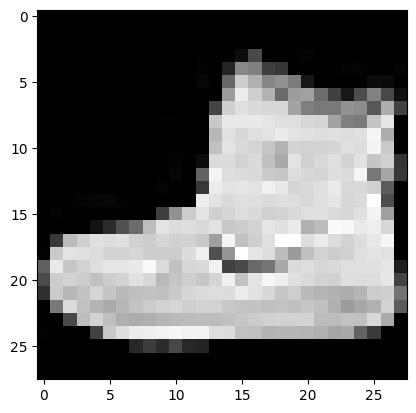

In [12]:
# Vizualize batch of training data 

image,label = trainset[0]

print("Image shape:",image.shape)
print("Label:",label)

plt.imshow(image.reshape(28,28),cmap="gray")

In [13]:
# Get classes 

classes = trainset.classes

print(classes)


['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [14]:
# Print target values 

target_values = trainset.targets

print(target_values.unique())

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


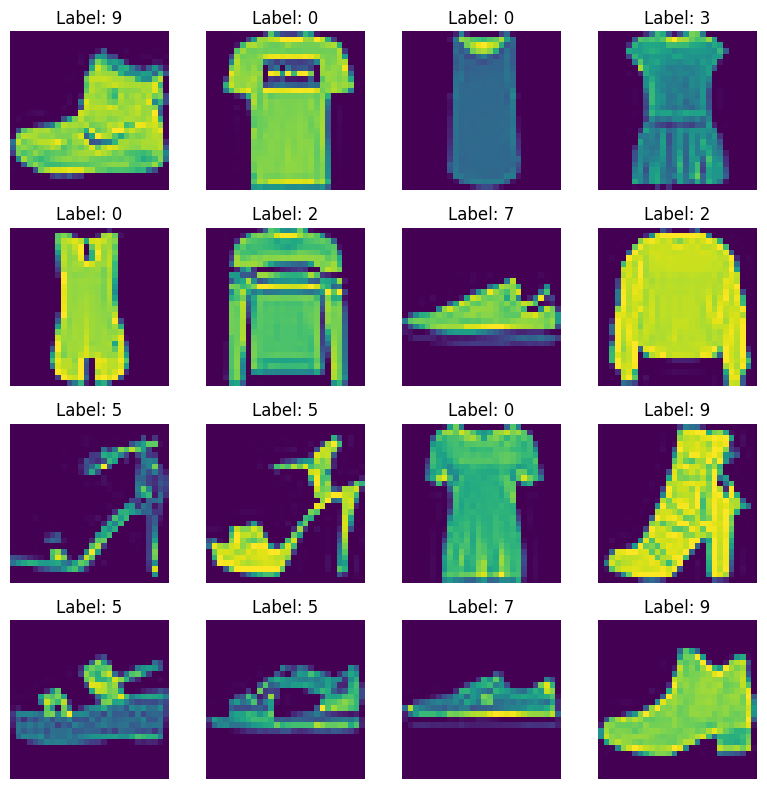

In [15]:
# Vizualize images 

figure, axs = plt.subplots(4, 4, figsize=(8, 8))

# Loop through each subplot
for x in range(4):
    for j in range(4):
        image, label = trainset[x * 4 + j]  # Get image and label
        image_numpy = image.numpy().squeeze()
        axs[x, j].imshow(image_numpy)  # Plot the image
        axs[x, j].axis('off')
        axs[x, j].set_title(f"Label: {label}")

plt.tight_layout()
plt.show()

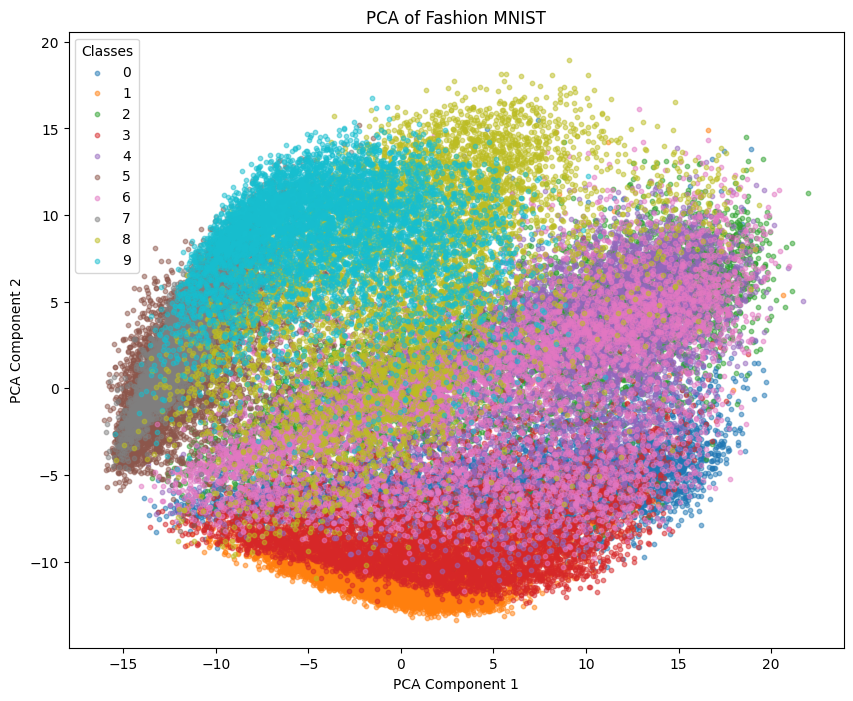

In [16]:
 # Dimensional Reduction Visualization 


images = []
labels = []

for i in range(len(trainset)):
    image, label = trainset[i]
    images.append(image.view(-1))  # Flatten the 28x28 image to a 784-dimensional vector
    labels.append(label)

# Convert images and labels to numpy arrays for PCA
images = np.array(images)
labels = np.array(labels)

# Apply PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(images)

# Plot the results
plt.figure(figsize=(10, 8))

# Use different colors for each class (digit)
for digit in range(10):
    indices = np.where(labels == digit)
    plt.scatter(reduced_data[indices, 0], reduced_data[indices, 1], label=str(digit), alpha=0.5, s=10)

plt.title("PCA of Fashion MNIST")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Classes")
plt.show()


### Model Implementation

In [26]:
# Create neural network
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [27]:
# Print model

model= Classifier()
print(model)

Classifier(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [28]:
# Define a function to calculate the accuracy of the model
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, 1) # Get the predicted classes from the output logits

  return torch.sum(preds == labels).item() / len(labels) # Return the ratio of correct predictions

In [29]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=5):


    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_acc = 0.0

        for images, labels in train_loader:
            images = images.to(device)  
            labels = labels.to(device)

            # Zero gradients, forward pass, loss, backward pass, optimize
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Update loss and accuracy
            running_loss += loss.item() * images.size(0)
            running_acc += accuracy(outputs, labels) * images.size(0)

        # Calculate average loss and accuracy
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_acc / len(train_loader.dataset)

        # Print results for the epoch
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

In [31]:
# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
train_model(model, trainloader, criterion, optimizer, num_epochs=10)

Epoch [1/10], Loss: 0.9278, Accuracy: 0.7039
Epoch [2/10], Loss: 0.5318, Accuracy: 0.8108
Epoch [3/10], Loss: 0.4697, Accuracy: 0.8326
Epoch [4/10], Loss: 0.4381, Accuracy: 0.8435
Epoch [5/10], Loss: 0.4175, Accuracy: 0.8515
Epoch [6/10], Loss: 0.3998, Accuracy: 0.8574
Epoch [7/10], Loss: 0.3854, Accuracy: 0.8622
Epoch [8/10], Loss: 0.3728, Accuracy: 0.8668
Epoch [9/10], Loss: 0.3618, Accuracy: 0.8702
Epoch [10/10], Loss: 0.3527, Accuracy: 0.8742
